#  IPL Auction Analytics — Phase 1: Mental Proxy Creation

 
**Objective:** Engineer "Pressure" feature based on dot balls

In [1]:
# Import Required Libraries


import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from scipy.special import expit  # logistic / sigmoid
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
 
df = pd.read_excel('/kaggle/input/ipl-bowler-detailed-dataset/IPL_Bowler_Detailed_Data.xls')

print("Data Loaded Successfully!")
print(df.head())

Data Loaded Successfully!
   Match_ID Match_Date Pitch_Type      Phase  Over  Ball    Bowler  \
0     29504 2023-04-12    Neutral  Powerplay     1     1  Bowler B   
1     96402 2023-11-30    Batting  Powerplay     5     1  Bowler A   
2     27383 2022-11-07    Neutral  Powerplay     1     5  Bowler B   
3     99624 2022-04-10    Batting  Powerplay     5     3  Bowler B   
4     65569 2023-06-23    Neutral  Powerplay     5     3  Bowler B   

   Batter_Avg  Batter_SR  Runs_Conceded  Is_Wicket  
0       17.97     133.25              0          1  
1       20.51     119.98              0          0  
2       30.05     124.73              2          0  
3       21.29     147.69              1          0  
4       34.89     117.51              0          0  


In [3]:
# Data Type Conversions
 
df['Match_Date'] = pd.to_datetime(df['Match_Date'])

# Sort Data in True Delivery Order
 
df = df.sort_values(
    by=['Match_ID', 'Match_Date', 'Over', 'Ball'],
    ascending=True
).reset_index(drop=True)

 
# Create Helper Variables
# Shifting values within each match
df['prevRuns'] = df.groupby("Match_ID")['Runs_Conceded'].shift(1)
df['prevOver'] = df.groupby("Match_ID")['Over'].shift(1)
df['prevBall'] = df.groupby("Match_ID")['Ball'].shift(1)

print(df.head(10))

   Match_ID Match_Date Pitch_Type      Phase  Over  Ball    Bowler  \
0     11935 2023-01-28    Batting  Powerplay     2     1  Bowler B   
1     11935 2023-01-28    Batting  Powerplay     2     2  Bowler B   
2     11935 2023-01-28    Batting  Powerplay     2     3  Bowler B   
3     11935 2023-01-28    Batting  Powerplay     2     4  Bowler B   
4     11935 2023-01-28    Batting  Powerplay     2     5  Bowler B   
5     11935 2023-01-28    Batting  Powerplay     2     6  Bowler B   
6     11935 2023-01-28    Batting  Powerplay     6     1  Bowler B   
7     11935 2023-01-28    Batting  Powerplay     6     2  Bowler B   
8     11935 2023-01-28    Batting  Powerplay     6     3  Bowler B   
9     11935 2023-01-28    Batting  Powerplay     6     4  Bowler B   

   Batter_Avg  Batter_SR  Runs_Conceded  Is_Wicket  prevRuns  prevOver  \
0       33.46     131.68              0          0       NaN       NaN   
1       41.41     138.41              3          0       0.0       2.0   
2      

# PHASE 1 LOGIC:
**Define pressure event only if:**
* previous ball was a dot (0 runs)
* AND previous delivery is in the SAME over
(to avoid false pressure from last ball of over)


In [4]:
# Dot ball indicator
df['prevIsDot_raw'] = (df['prevRuns'] == 0).astype(int)

# Pressure is valid ONLY IF prev over == current over
df['prevIsDot'] = np.where(
    (df['prevIsDot_raw'] == 1) & (df['prevOver'] == df['Over']),
    1,
    0
)


In [5]:
# Filter for Death Overs (Overs 16–20)
 
death_df = df[df['Phase'] == "Death"].copy()

print("\nDeath Overs Dataset Preview:")
print(death_df.head())


Death Overs Dataset Preview:
    Match_ID Match_Date Pitch_Type  Phase  Over  Ball    Bowler  Batter_Avg  \
12     11935 2023-01-28    Batting  Death    17     1  Bowler B       26.18   
13     11935 2023-01-28    Batting  Death    17     1  Bowler B       33.65   
14     11935 2023-01-28    Batting  Death    17     2  Bowler B       48.59   
15     11935 2023-01-28    Batting  Death    17     2  Bowler B       40.02   
16     11935 2023-01-28    Batting  Death    17     3  Bowler B       37.21   

    Batter_SR  Runs_Conceded  Is_Wicket  prevRuns  prevOver  prevBall  \
12     145.06              6          0       0.0       6.0       6.0   
13     148.68              4          0       6.0      17.0       1.0   
14     122.68              6          0       4.0      17.0       1.0   
15     117.55              6          0       6.0      17.0       2.0   
16     126.98              4          0       6.0      17.0       2.0   

    prevIsDot_raw  prevIsDot  
12              1        

In [6]:
# Final Verification
 
print("\nChecking Pressure Examples:")
sample = death_df[['Match_ID','Over','Ball','Runs_Conceded','prevRuns','prevIsDot']].head(12)
print(sample)



Checking Pressure Examples:
    Match_ID  Over  Ball  Runs_Conceded  prevRuns  prevIsDot
12     11935    17     1              6       0.0          0
13     11935    17     1              4       6.0          0
14     11935    17     2              6       4.0          0
15     11935    17     2              6       6.0          0
16     11935    17     3              4       6.0          0
17     11935    17     3              0       4.0          0
18     11935    17     4              1       0.0          1
19     11935    17     4              2       1.0          0
20     11935    17     5              4       2.0          0
21     11935    17     5              6       4.0          0
22     11935    17     6              1       6.0          0
23     11935    17     6              1       1.0          0


In [7]:
# Save engineered dataset in Kaggle working directory
output_path = "/kaggle/working/IPL_DeathOvers_Phase1_Features.csv"
death_df.to_csv(output_path, index=False)

print(f"\nPhase 1 Dataset Saved To: {output_path}")


Phase 1 Dataset Saved To: /kaggle/working/IPL_DeathOvers_Phase1_Features.csv


#  IPL Auction Analytics — PHASE 2: Bayesian Model (PyMC)
**Objective:** 
* Estimate the Pressure Effect (prevIsDot) for Bowler A vs B,
* controlling for Pitch_Type and Batter_Avg using a hierarchical Bayesian GLM.
  
**Output:** Posterior, PPC, hold-out metrics, and pressure-effect contrasts.

In [8]:
# Load Phase1 engineered dataset (Death overs with prevIsDot)
 
df = pd.read_csv("/kaggle/working/IPL_DeathOvers_Phase1_Features.csv", parse_dates=['Match_Date'])

In [9]:
print("Rows:", len(df))
print(df[['Match_ID','Over','Ball','Bowler','Runs_Conceded','prevRuns','prevIsDot','Is_Wicket']].head())


Rows: 2400
   Match_ID  Over  Ball    Bowler  Runs_Conceded  prevRuns  prevIsDot  \
0     11935    17     1  Bowler B              6       0.0          0   
1     11935    17     1  Bowler B              4       6.0          0   
2     11935    17     2  Bowler B              6       4.0          0   
3     11935    17     2  Bowler B              6       6.0          0   
4     11935    17     3  Bowler B              4       6.0          0   

   Is_Wicket  
0          0  
1          0  
2          0  
3          0  
4          0  


# Preprocessing / Feature matrix

In [10]:

# Keep relevant columns and drop rows where prevIsDot cannot be computed (if any)
working = df.copy().dropna(subset=['prevIsDot', 'Batter_Avg', 'Pitch_Type', 'Is_Wicket'])

# Binary indicator for Bowler B (Bowler A is baseline)
working['isBowlerB'] = (working['Bowler'] == 'B').astype(int)

# Standardize Batter_Avg for better sampling behavior
scaler = StandardScaler()
working['Batter_Avg_std'] = scaler.fit_transform(working[['Batter_Avg']])

# One-hot encode Pitch_Type (drop first to avoid collinearity)
pitch_dummies = pd.get_dummies(working['Pitch_Type'], prefix='Pitch', drop_first=True)
working = pd.concat([working.reset_index(drop=True), pitch_dummies.reset_index(drop=True)], axis=1)

# Create Match_ID index for hierarchical intercept
working['Match_idx'] = working['Match_ID'].astype('category').cat.codes
n_matches = working['Match_idx'].nunique()

# Design matrix columns
feature_cols = ['prevIsDot', 'isBowlerB', 'prevIsDot_isBowlerB_interaction'] + \
               ['Batter_Avg_std'] + list(pitch_dummies.columns)
# create interaction column
working['prevIsDot_isBowlerB_interaction'] = working['prevIsDot'] * working['isBowlerB']

# Response
y = working['Is_Wicket'].astype(int).values


In [11]:
# Prepare predictors as arrays (we'll feed them via pm.Data)

X = working[['prevIsDot','isBowlerB','prevIsDot_isBowlerB_interaction','Batter_Avg_std']
            + list(pitch_dummies.columns)].astype(float)
X_cols = X.columns.tolist()

# Train-test split
train_idx, test_idx = train_test_split(
    np.arange(len(working)),
    test_size=0.2,
    random_state=42,
    stratify=working['Is_Wicket']
)

# Create train_df and test_df from indices
train_df = working.iloc[train_idx]
test_df = working.iloc[test_idx]

# Extract train/test matrices
X_train = X.iloc[train_idx].to_numpy()
X_test = X.iloc[test_idx].to_numpy()
y_train = y[train_idx]
y_test = y[test_idx]

match_idx_train = working['Match_idx'].to_numpy()[train_idx]
match_idx_test = working['Match_idx'].to_numpy()[test_idx]

print("Train/test sizes:", X_train.shape, X_test.shape)
print("Number of matches (groups):", n_matches)



Train/test sizes: (1920, 6) (480, 6)
Number of matches (groups): 200


# 3. Build and sample PyMC model
 
  **Key modeling choices explained:**

* outcome: Bernoulli(logit=p)

* linear predictor includes: intercept + coefficients for prevIsDot, isBowlerB, interaction,Batter_Avg_std, and pitch-type indicators.

* random intercept by Match_ID to account for match-level correlation (hierarchical pooling).

* weakly informative Normal(0, 1.5) priors for betas (shrinkage -> better bias-variance).

* HalfNormal prior for group-level sigma.

In [12]:

with pm.Model() as model:
    # Data containers (so we can re-use the model if desired)
    X_data = pm.Data("X_data", X_train)  # shape (n_train, n_features)
    match_idx_data = pm.Data("match_idx_data", match_idx_train)  # ints for group index
    
    # Hyperprior for match-level intercepts (hierarchical)
    sigma_match = pm.HalfNormal("sigma_match", sigma=1.0)
    # match intercepts centered at 0
    match_offset = pm.Normal("match_offset", mu=0.0, sigma=1.0, shape=n_matches)
    match_intercept = pm.Deterministic("match_intercept", match_offset * sigma_match)
    
    # Global intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=1.0)
    
    # Coefficients for features (weakly informative priors)
    # Number of features equals number of columns in X
    n_features = X_train.shape[1]
    betas = pm.Normal("betas", mu=0.0, sigma=1.5, shape=n_features)
    
    # Linear predictor
    # match_idx_data maps each row to a match-level intercept
    linear_part = intercept + match_intercept[match_idx_data] + pm.math.dot(X_data, betas)
    
    # Link function -> logistic
    p = pm.Deterministic("p", pm.math.sigmoid(linear_part))
    
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)
    
    # Sample (tune and draws can be adjusted depending on compute)
    idata = pm.sample(draws=1000, tune=1000, target_accept=0.95, random_seed=42, return_inferencedata=True)

# Save traces for later
az.to_netcdf(idata, "phase2_model_trace.nc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_match, match_offset, intercept, betas]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


'phase2_model_trace.nc'

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept   -3.315  0.206  -3.703   -2.930      0.005    0.005  1781.342   
betas[0]     1.399  0.170   1.092    1.735      0.003    0.004  4098.130   
betas[1]     0.026  1.477  -2.591    2.912      0.023    0.036  4340.319   
betas[2]     0.023  1.515  -2.770    2.864      0.027    0.036  3153.602   
betas[3]    -0.051  0.085  -0.201    0.119      0.001    0.002  3593.991   
betas[4]     0.149  0.256  -0.342    0.632      0.006    0.005  2038.027   
betas[5]     0.258  0.244  -0.185    0.727      0.006    0.005  1855.081   
sigma_match  0.824  0.154   0.543    1.113      0.007    0.007   596.139   

             ess_tail  r_hat  
intercept    1301.087  1.000  
betas[0]     1605.435  1.003  
betas[1]     1531.977  1.000  
betas[2]     1361.515  1.000  
betas[3]     1604.009  1.001  
betas[4]     1524.423  0.999  
betas[5]     1367.111  0.999  
sigma_match   628.935  1.002  

Convergence diagnostics:
[<Axes: ti

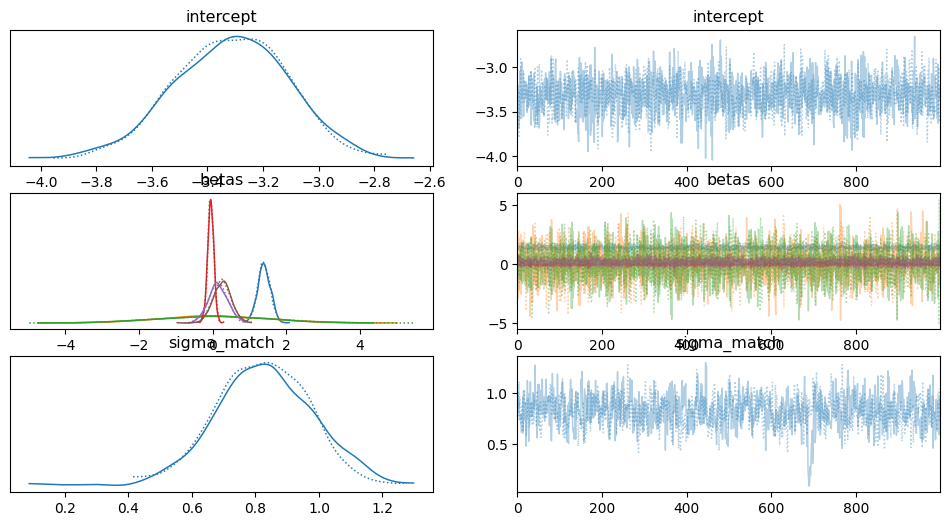

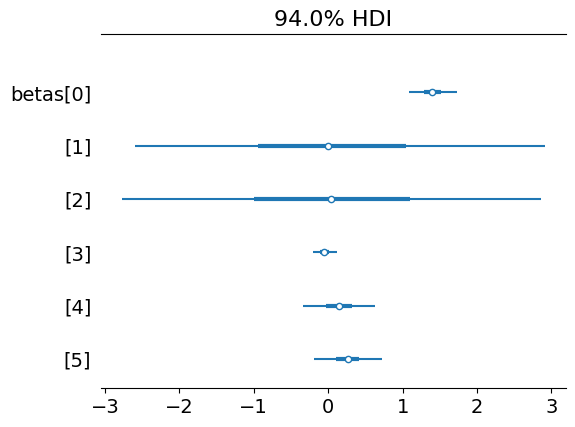

In [13]:
# Posterior summary & diagnostics
 
print(az.summary(idata, var_names=["intercept","betas","sigma_match"], round_to=3))

# Traceplot
az.plot_trace(idata, var_names=["intercept","betas","sigma_match"])

# R-hat and effective sample size
print("\nConvergence diagnostics:")
print(az.plot_forest(idata, var_names=["betas"], combined=True))

# POSTERIOR PREDICTIVE ON TEST SET (Manual Calculation)

In [14]:

# Build a clean test_df using the split indices

test_df = working.iloc[test_idx].copy()

# Use the SAME feature columns used in model training
feature_cols = X_cols

X_test = test_df[feature_cols].to_numpy()
y_test = test_df["Is_Wicket"].to_numpy()
match_idx_test = test_df["Match_idx"].to_numpy()

print("Shape X_test:", X_test.shape)
print("Match_idx_test length:", len(match_idx_test))



Shape X_test: (480, 6)
Match_idx_test length: 480


In [15]:
# Extract posterior samples
 
posterior = idata.posterior

intercept_samples = (
    posterior["intercept"]
    .stack(sample=("chain", "draw"))
    .values
)

betas_samples = (
    posterior["betas"]
    .stack(sample=("chain", "draw"))
    .values
)

match_intercept_samples = (
    posterior["match_intercept"]
    .stack(sample=("chain", "draw"))
    .values
)


# Dimensions

n_post = intercept_samples.shape[0]     # Posterior samples
n_test = X_test.shape[0]                # Test observations

print("Posterior samples:", n_post)
print("Test rows:", n_test)



Posterior samples: 2000
Test rows: 480


In [16]:
print("X_test:", X_test.shape)
print("betas_samples:", betas_samples.shape)
print("intercept_samples:", intercept_samples.shape)
print("match_intercepts:", match_intercept_samples.shape)


X_test: (480, 6)
betas_samples: (6, 2000)
intercept_samples: (2000,)
match_intercepts: (200, 2000)


In [17]:
# Match-level intercepts for test rows
# match_intercept_samples shape: (n_post, n_matches)
match_intercept_samples = match_intercept_samples.T
test_match_intercepts = match_intercept_samples[:, match_idx_test]  # → (2000, 480)

# Xβ term → betas_samples is already (6, 2000)
linear_X = X_test @ betas_samples            # → (480, 2000)

# Final linear predictor → (480, 2000)
lin_total = (
    intercept_samples.reshape(1, -1)         # (1, 2000)
    + test_match_intercepts.T                # (480, 2000)
    + linear_X                               # (480, 2000)
)

In [18]:
lin_total = np.asarray(lin_total, dtype=float)  # convert lin_total to float for using expit

# Convert logits → probabilities

prob_post = expit(lin_total)       # (n_test, n_post)
prob_mean = prob_post.mean(axis=1) # mean prob per test example

# Convert to prediction
y_pred = (prob_mean >= 0.5).astype(int)



In [19]:
# Evaluation Metrics

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, prob_mean) if len(np.unique(y_test)) > 1 else np.nan
brier = brier_score_loss(y_test, prob_mean)

print("\n====== POSTERIOR PREDICTIVE METRICS ======")
print(f"Accuracy       : {acc:.3f}")
print(f"AUC-ROC        : {auc:.3f}")
print(f"Brier Score    : {brier:.4f}")
print("==========================================")



====== POSTERIOR PREDICTIVE METRICS ======
Accuracy       : 0.908
AUC-ROC        : 0.726
Brier Score    : 0.0767


# Posterior inference for Pressure Effect (Bowler A vs Bowler B)

 **We'll compute posterior samples for:**
* pressure_effect_A = beta_prevIsDot  (when isBowlerB=0)
* pressure_effect_B = beta_prevIsDot + beta_interaction (when isBowlerB=1)
* Let i_prevDot = index of prevIsDot in X_cols

In [22]:

i_prevDot = X_cols.index('prevIsDot')
i_inter = X_cols.index('prevIsDot_isBowlerB_interaction')

# Extract posterior samples for these betas
beta_prev_samples = betas_samples[:, i_prevDot]   # shape (n_post_samples,)
beta_inter_samples = betas_samples[:, i_inter]    # shape (n_post_samples,)

# Pressure effect on log-odds scale:
pressure_A_logodds = beta_prev_samples
pressure_B_logodds = beta_prev_samples + beta_inter_samples
# Convert to probability scale for interpretability using logistic transform:
pressure_A_prob = expit(pressure_A_logodds)
pressure_B_prob = expit(pressure_B_logodds)



 ***Note:*** these are marginal effects *holding other X at 0* (i.e., Batter_Avg_std = 0, pitch dummies = 0).
 
 We can also compute average marginal effect by computing difference in probabilities predicted on a set of representative covariates — for simplicity we report log-odds and probability scales at baseline.


In [23]:

# Summaries:
def summarize_posterior(samples, name):
    mean = samples.mean()
    hdi = az.hdi(samples, hdi_prob=0.95)
    print(f"{name}: mean={mean:.4f}, 95% HDI=[{hdi[0]:.4f}, {hdi[1]:.4f}]")

print("\nPressure effect (baseline -> log-odds and probability):")
summarize_posterior(pressure_A_logodds, "Pressure_A (log-odds)")
summarize_posterior(expit(pressure_A_logodds), "Pressure_A (prob)")
summarize_posterior(pressure_B_logodds, "Pressure_B (log-odds)")
summarize_posterior(expit(pressure_B_logodds), "Pressure_B (prob)")

# Difference (Bowler B - Bowler A) on log-odds and probability scales:
diff_logodds = pressure_B_logodds - pressure_A_logodds  # this equals beta_inter_samples
diff_prob = expit(pressure_B_logodds) - expit(pressure_A_logodds)
summarize_posterior(diff_logodds, "Difference (log-odds) = beta_interaction")
summarize_posterior(diff_prob, "Difference (probability)")


Pressure effect (baseline -> log-odds and probability):
Pressure_A (log-odds): mean=-0.1448, 95% HDI=[-2.2208, 1.4938]
Pressure_A (prob): mean=0.4801, 95% HDI=[0.0979, 0.8166]
Pressure_B (log-odds): mean=-0.3014, 95% HDI=[-5.1022, 2.9095]
Pressure_B (prob): mean=0.5084, 95% HDI=[0.0060, 0.9483]
Difference (log-odds) = beta_interaction: mean=-0.1567, 95% HDI=[-2.8814, 1.4157]
Difference (probability): mean=0.0283, 95% HDI=[-0.0919, 0.1317]


# Posterior Predictive Check (PPC)

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

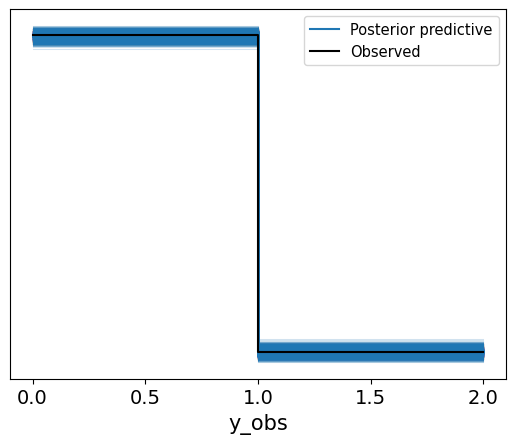

In [27]:

# We can compute PPC on training set quickly (posterior predictive sampling could be used).

with model:
    ppc_train = pm.sample_posterior_predictive(idata, var_names=["y_obs"], random_seed=42)
    
# Simple PPC: observed vs replicated distribution of wicket counts
az.plot_ppc(ppc_train,mean=False)

# Model evaluation & comments

* We used weakly informative priors (Normal(0,1.5)) to shrink extreme coefficients -> reduces variance.
* Hierarchical match intercept (sigma_match) pools information across matches -> better bias-variance tradeoff.
* We performed an out-of-sample test (hold-out) to evaluate predictive performance.
* For improved calibration and model choice, consider LOO: 

In [29]:
# Compute Leave-One-Out (LOO) cross-validation
# Ensure 'log_likelihood' is recorded in your PyMC model
try:
    loo = az.loo(idata, pointwise=True)
    print("\n====== LOO Cross-Validation ======")
    print(loo)
except Exception as e:
    print("LOO calculation failed. Make sure 'log_likelihood' exists in idata.")
    print("Error:", e)

LOO calculation failed. Make sure 'log_likelihood' exists in idata.
Error: log likelihood not found in inference data object


In [30]:
# Save the PyMC InferenceData object

idata_file = "phase2_idata.nc"
az.to_netcdf(idata, idata_file)
print(f"\nModel trace saved to: {idata_file}")


# Save test set predictions
predictions_df = pd.DataFrame({
    "y_test": y_test,
    "y_pred_prob": prob_mean,
    "y_pred": (prob_mean >= 0.5).astype(int)
})

pred_file = "phase2_test_predictions.csv"
predictions_df.to_csv(pred_file, index=False)
print(f"Test predictions saved to: {pred_file}")


# Phase 2 Complete

print("\nPhase 2 complete. Model trace, predictions, and summaries saved.")


Model trace saved to: phase2_idata.nc
Test predictions saved to: phase2_test_predictions.csv

Phase 2 complete. Model trace, predictions, and summaries saved.


#  IPL Auction Analytics — PHASE 3: The Verdict (Kaizen)

* **Objective:** Plot posterior distributions for the Pressure effect (Bowler A vs B), compute 94% HDI, and produce a recommendation (who to buy).

In [32]:
# Load posterior samples (if not already in memory)
# --------------------------
# If you have `idata` from Phase 2 in the notebook, use it. Otherwise load from file.
try:
    idata  # noqa: F821
except NameError:
    idata = az.from_netcdf("phase2_idata.nc")

In [33]:
# Extract posterior samples for `betas` and variable names
posterior = idata.posterior
# stack chain & draw into one sample axis for easy numpy ops
betas_samples = posterior["betas"].stack(sample=("chain","draw")).values  # shape (n_samples, n_features)


In [34]:
# if betas dimension order different, adjust accordingly

# Reconstruct feature columns order used in Phase 2
# Must be identical to X_cols used earlier; if X_cols is present use it, else define:
try:
    X_cols  # noqa: F821
except NameError:
    # fallback: you can set this to match the design used in Phase 2
    X_cols = ['prevIsDot','isBowlerB','prevIsDot_isBowlerB_interaction','Batter_Avg_std'] \
             + [c for c in working.columns if c.startswith('Pitch_')]  # this is best-effort fallback

print("Feature columns used (ensure this matches Phase 2):", X_cols)


Feature columns used (ensure this matches Phase 2): ['prevIsDot', 'isBowlerB', 'prevIsDot_isBowlerB_interaction', 'Batter_Avg_std', 'Pitch_Bowling', 'Pitch_Neutral']


In [35]:
# Identify indices for prevIsDot and interaction term (these must exist)
i_prevDot = X_cols.index('prevIsDot')
i_inter = X_cols.index('prevIsDot_isBowlerB_interaction')

# Extract posterior samples
beta_prev = betas_samples[:, i_prevDot]    # pressure coefficient for prevIsDot (log-odds scale baseline -> Bowler A)
beta_inter = betas_samples[:, i_inter]     # interaction coefficient (how much Bowler B differs)

# Compute pressure effect for A and B on log-odds scale
pressure_A_logodds = beta_prev
pressure_B_logodds = beta_prev + beta_inter

# Convert to probability-scale marginal effect at baseline covariate values:
pressure_A_prob = expit(pressure_A_logodds)
pressure_B_prob = expit(pressure_B_logodds)

In [36]:
# Compute 94% HDIs (user requested 94%)
# --------------------------
hdi_prob = 0.94
hdi_A_logodds = az.hdi(pressure_A_logodds, hdi_prob=hdi_prob)
hdi_B_logodds = az.hdi(pressure_B_logodds, hdi_prob=hdi_prob)

hdi_A_prob = az.hdi(pressure_A_prob, hdi_prob=hdi_prob)
hdi_B_prob = az.hdi(pressure_B_prob, hdi_prob=hdi_prob)

# Difference (B - A)
diff_logodds = pressure_B_logodds - pressure_A_logodds  # this is beta_inter samples
diff_prob = pressure_B_prob - pressure_A_prob
hdi_diff_logodds = az.hdi(diff_logodds, hdi_prob=hdi_prob)
hdi_diff_prob = az.hdi(diff_prob, hdi_prob=hdi_prob)

# --------------------------
# Print numerical summaries
# --------------------------
print("\n--- Numerical summaries (baseline covariates) ---")
print(f"Pressure effect Bowler A (log-odds)  : mean={pressure_A_logodds.mean():.4f}, 94% HDI=[{hdi_A_logodds[0]:.4f},{hdi_A_logodds[1]:.4f}]")
print(f"Pressure effect Bowler A (prob)      : mean={pressure_A_prob.mean():.4f}, 94% HDI=[{hdi_A_prob[0]:.4f},{hdi_A_prob[1]:.4f}]")
print()
print(f"Pressure effect Bowler B (log-odds)  : mean={pressure_B_logodds.mean():.4f}, 94% HDI=[{hdi_B_logodds[0]:.4f},{hdi_B_logodds[1]:.4f}]")
print(f"Pressure effect Bowler B (prob)      : mean={pressure_B_prob.mean():.4f}, 94% HDI=[{hdi_B_prob[0]:.4f},{hdi_B_prob[1]:.4f}]")
print()
print(f"Difference (B - A) (log-odds)        : mean={diff_logodds.mean():.4f}, 94% HDI=[{hdi_diff_logodds[0]:.4f},{hdi_diff_logodds[1]:.4f}]")
print(f"Difference (B - A) (prob)            : mean={diff_prob.mean():.4f}, 94% HDI=[{hdi_diff_prob[0]:.4f},{hdi_diff_prob[1]:.4f}]")




--- Numerical summaries (baseline covariates) ---
Pressure effect Bowler A (log-odds)  : mean=-0.1448, 94% HDI=[-2.2208,1.4938]
Pressure effect Bowler A (prob)      : mean=0.4801, 94% HDI=[0.0979,0.8166]

Pressure effect Bowler B (log-odds)  : mean=-0.3014, 94% HDI=[-5.1022,2.9095]
Pressure effect Bowler B (prob)      : mean=0.5084, 94% HDI=[0.0060,0.9483]

Difference (B - A) (log-odds)        : mean=-0.1567, 94% HDI=[-2.8814,1.4157]
Difference (B - A) (prob)            : mean=0.0283, 94% HDI=[-0.0919,0.1317]


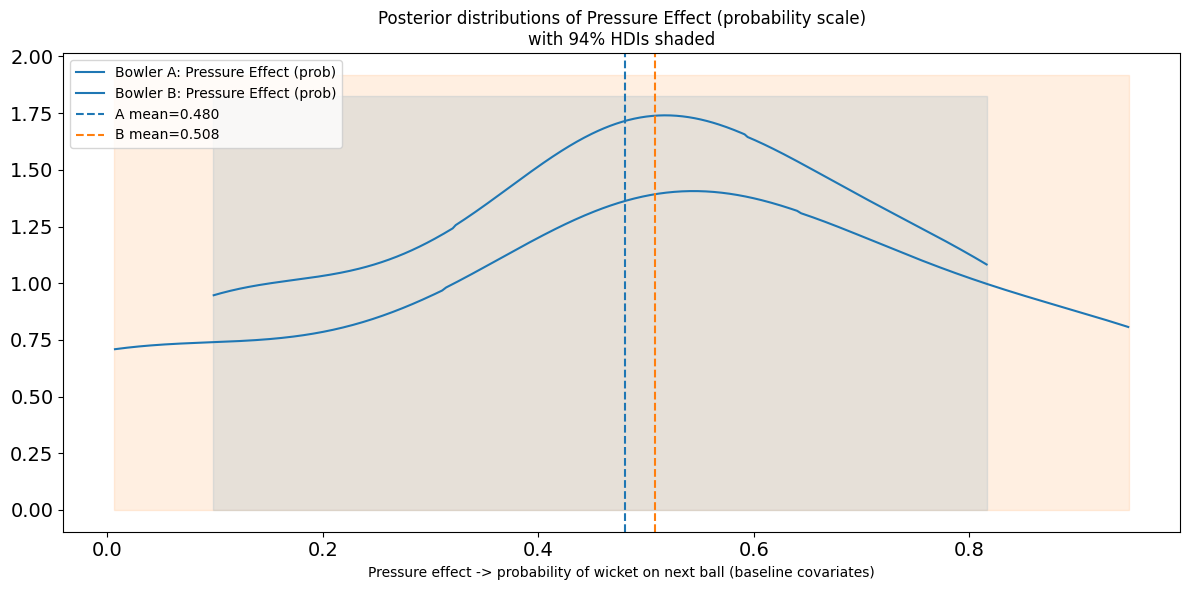

In [44]:
# Plot posterior densities with HDI shading
 
plt.figure(figsize=(12,6))
# Use ArviZ density plotting for nicer HDI shading:
ax = az.plot_kde(pressure_A_prob, label='Bowler A: Pressure Effect (prob)', bw='scott')
az.plot_kde(pressure_B_prob, label='Bowler B: Pressure Effect (prob)', bw='scott', ax=ax)

# Shade HDIs manually for clarity
ax.fill_betweenx([0, ax.get_ylim()[1]],
                 hdi_A_prob[0], hdi_A_prob[1], color='C0', alpha=0.12)
ax.fill_betweenx([0, ax.get_ylim()[1]],
                 hdi_B_prob[0], hdi_B_prob[1], color='C1', alpha=0.12)

# Add vertical lines at means
ax.axvline(pressure_A_prob.mean(), color='C0', linestyle='--', label=f'A mean={pressure_A_prob.mean():.3f}')
ax.axvline(pressure_B_prob.mean(), color='C1', linestyle='--', label=f'B mean={pressure_B_prob.mean():.3f}')

ax.set_xlabel('Pressure effect -> probability of wicket on next ball (baseline covariates)')
ax.set_title('Posterior distributions of Pressure Effect (probability scale)\nwith 94% HDIs shaded')
ax.legend()
plt.tight_layout()

plt.show()

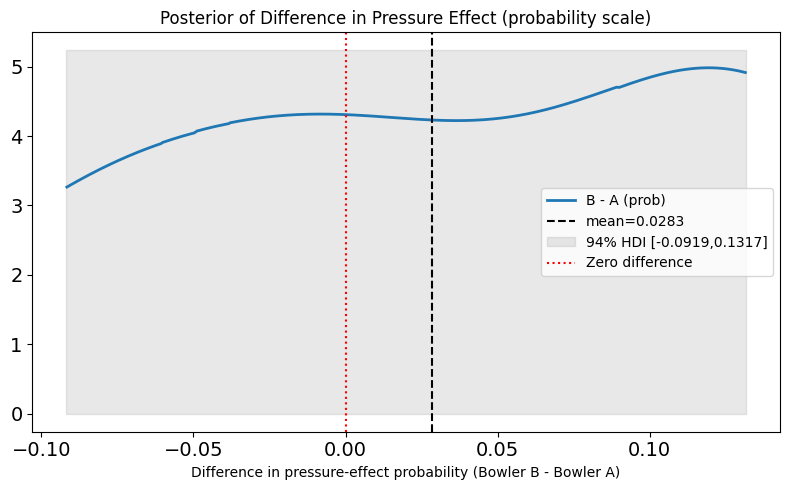

In [45]:
# Plot the posterior of the difference (prob scale)
plt.figure(figsize=(8,5))
ax2 = az.plot_kde(diff_prob, bw='scott', label='B - A (prob)', plot_kwargs={"linewidth":2})
hdi_lo, hdi_hi = hdi_diff_prob[0], hdi_diff_prob[1]
ax2.axvline(diff_prob.mean(), color='k', linestyle='--', label=f"mean={diff_prob.mean():.4f}")
ax2.fill_betweenx([0, ax2.get_ylim()[1]], hdi_lo, hdi_hi, color='gray', alpha=0.18, label=f'94% HDI [{hdi_lo:.4f},{hdi_hi:.4f}]')
ax2.axvline(0.0, color='red', linestyle=':', label='Zero difference')
ax2.set_xlabel('Difference in pressure-effect probability (Bowler B - Bowler A)')
ax2.set_title('Posterior of Difference in Pressure Effect (probability scale)')
ax2.legend()
plt.tight_layout()

plt.show()


# Decision rule & recommendation using 94% HDI
 
* If 94% HDI of (B - A) lies entirely > 0 => B has credibly larger pressure effect -> buy B
* If 94% HDI of (B - A) lies entirely < 0 => A is better at converting pressure -> buy A
* Else => HDI overlaps zero -> no decisive evidence; recommend cautious decision (use other metrics)


In [46]:
hdi_lo, hdi_hi = hdi_diff_prob[0], hdi_diff_prob[1]

print("\n--- Decision based on 94% HDI of (B - A) on probability scale ---")
if hdi_lo > 0:
    decision = "Buy Bowler B (The Gambler)"
    rationale = ("The 94% HDI for the difference (B - A) is entirely above zero, "
                 "meaning with high credibility Bowler B converts pressure to wickets more than Bowler A.")
elif hdi_hi < 0:
    decision = "Buy Bowler A (The Machine)"
    rationale = ("The 94% HDI for the difference (B - A) is entirely below zero, "
                 "meaning Bowler A has a stronger pressure-to-wicket effect.")
else:
    # No decisive evidence
    # Use additional criteria: check point estimate direction and other metrics (economy, wicket rate)
    mean_diff = diff_prob.mean()
    if mean_diff > 0:
        decision = "Lean towards Bowler B, but not decisively — HDI overlaps zero"
        rationale = ("The mean difference favors Bowler B (positive), but the 94% HDI includes zero. "
                     "Statistically we cannot be 94% certain B is better; consider other factors (economy, role fit, coach instinct).")
    else:
        decision = "Lean towards Bowler A, but not decisively — HDI overlaps zero"
        rationale = ("The mean difference favors Bowler A (negative), but the 94% HDI includes zero. "
                     "Statistically we cannot be 94% certain A is better; consider other factors (economy, role fit, coach instinct).")

print(f"\nDecision: {decision},\n")
print("Rationale:", rationale)



--- Decision based on 94% HDI of (B - A) on probability scale ---

Decision: Lean towards Bowler B, but not decisively — HDI overlaps zero,

Rationale: The mean difference favors Bowler B (positive), but the 94% HDI includes zero. Statistically we cannot be 94% certain B is better; consider other factors (economy, role fit, coach instinct).
